remaining_contract
remaining contract = 0 не відпала
                = None не відпала

  - скільки залишилось контракту. після 12міс. залишився помісчно по передплаті.

якщо майже закінчився контракт (0 або None) - натренувати.
далі дивитись коли відпадає і давати %вірогідності що відвалиться

In [10]:
# Data preparation for remaining_contract 0 or -1
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer, GaussianNoise
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
# from tensorflow.keras.optimizers import Nadam
import pandas as pd

df = pd.read_csv('cleaned_remaining_na_-1.csv')  # Замініть на ваш файл даних

df_remaining = df[(df['remaining_contract']==-1) | (df['remaining_contract']==0)]

X = df_remaining.drop(columns=['id', 'churn',"service_failure_count"])
y = df_remaining['churn']

# Поділ на тренувальний, тестовий та валідаційний набори
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Нормалізація даних
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)

In [11]:
grouped = df_remaining.groupby('churn')
group_sizes = grouped.size()
group_sizes

churn
0     1871
1    36010
dtype: int64

In [12]:
# Best model
# layers=2_units=512_dropout=0.0_batch_size=16_activation=tanh

# Параметри моделі
loss_f = 'binary_crossentropy'
metrics = 'accuracy'

# dropout_rate = 0.2 # 0.3,0.4 не маэ сенсу. завжди гірше
batch_size = 16
units1 = 512
units2 = 512
activation = 'tanh'
optimizer =  'adam' #Nadam(learning_rate=0.001)

# Створення моделі
model = Sequential()
model.add(InputLayer(shape=(X_train_scaled.shape[1],)))
model.add(Dense(units1, activation=activation)) #, activation='relu' - результат трохи гірший , kernel_regularizer=l2(1e-4)) - не має сенсу. результат гірше
# model.add(Dropout(dropout_rate))       #  -  не має сенсу, результат гірше
model.add(Dense(units2, activation=activation)) #, activation='relu' , kernel_regularizer=l2(1e-4)
# model.add(Dropout(dropout_rate))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss=loss_f, optimizer=optimizer, metrics=[metrics])

# Early stopping та learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)

# Друк інформації про модель
print('---------------------------------------')
print(f"Training model with 2 layers, units: {units1}+{units2}, batch_size: {batch_size}, activation: {activation}") #layers: {layers}, dropout: {dropout_rate},
# Тренування моделі
history = model.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val),
                    epochs=50,batch_size=batch_size,callbacks=[early_stopping, reduce_lr], verbose=1) #     callbacks=[early_stopping, reduce_lr]

# Оцінка моделі на тестових даних
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy for model: {accuracy}")

---------------------------------------
Training model with 2 layers, units: 512+512, batch_size: 16, activation: tanh
Epoch 1/50
1658/1658 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9264 - loss: 0.1992 - val_accuracy: 0.9491 - val_loss: 0.1509 - learning_rate: 0.0010
Epoch 2/50
1658/1658 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9485 - loss: 0.1439 - val_accuracy: 0.9534 - val_loss: 0.1377 - learning_rate: 0.0010
Epoch 3/50
1658/1658 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9480 - loss: 0.1435 - val_accuracy: 0.9525 - val_loss: 0.1411 - learning_rate: 0.0010
Epoch 4/50
1658/1658 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9472 - loss: 0.1448 - val_accuracy: 0.9530 - val_loss: 0.1392 - learning_rate: 0.0010
Epoch 5/50
1658/1658 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9469 - loss: 0.1446 - val_accuracy: 0.9530 - val_loss: 0.1371 - learning_rate: 5.0000e-04
Epoch 6/50
1658/1658 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9475 - loss: 0.1406 - val_accurac

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Assuming y_test is the true labels and y_pred is the predicted labels
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")

# Оцінка моделі на тестових даних
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.4f}")

# Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# Full Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.9565
Recall: 0.9961
Precision: 0.9599
F1 Score: 0.9777

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.08      0.14       246
           1       0.96      1.00      0.98      5437

    accuracy                           0.96      5683
   macro avg       0.72      0.54      0.56      5683
weighted avg       0.94      0.96      0.94      5683



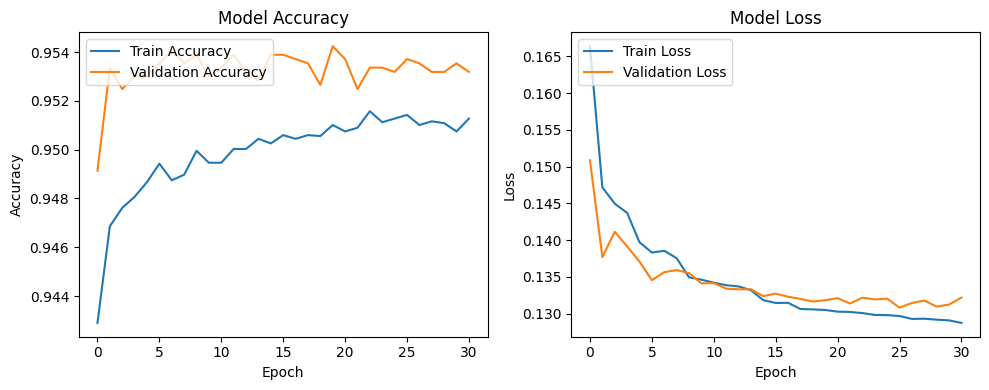

In [14]:
import matplotlib.pyplot as plt

# Create a figure with 2 subplots in 1 row
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# First subplot - Model Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(loc='upper left')

# Second subplot - Model Loss
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(loc='upper left')

# Adjust layout for a clean look
plt.tight_layout()
plt.show()


In [15]:
# import tensorflow as tf
import keras
file_name = f"Remaining_l2_adam_units_{units1}+{units2}_batch_{batch_size}_activation_{activation}.keras"
keras.saving.save_model(model, file_name)